In [1]:
import arviz as az
import bokeh.plotting as bkp  
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from bokeh.io import output_notebook, show
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.models.annotations import Title
from bokeh.models.widgets import Select
from bokeh.palettes import brewer
from bokeh.transform import linear_cmap

output_notebook()
BINS = np.array([15., 25., 35., 45., 55., 65., 75.])
COLORS = {
    "farleft": np.array(brewer["Reds"][7][::-1]),
    "left": np.array(brewer["PuRd"][7][::-1]),
    "green": np.array(brewer["Greens"][7][::-1]),
    "center": np.array(brewer["Oranges"][7][::-1]),
    "right": np.array(brewer["Blues"][7][::-1]),
    "farright": np.array(brewer["Purples"][7][::-1]),
    "other": np.array(brewer["Greys"][7][::-1]),
}
PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]

import bokeh.plotting as bkp

from bokeh.io import output_notebook, show
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.models.annotations import Title
from bokeh.models.widgets import Select
from bokeh.palettes import brewer, cividis
from bokeh.transform import linear_cmap

output_notebook()
BINS = np.array([15., 25., 35., 45., 55., 65., 75.])
COLORS = {
    "farleft": np.array(brewer["Reds"][7][::-1]),
    "left": np.array(brewer["PuRd"][7][::-1]),
    "green": np.array(brewer["Greens"][7][::-1]),
    "center": np.array(brewer["Oranges"][7][::-1]),
    "right": np.array(brewer["Blues"][7][::-1]),
    "farright": np.array(brewer["Purples"][7][::-1]),
    "other": np.array(brewer["Greys"][7][::-1]),
}

Loading BokehJS ...

In [2]:
az.style.use("arviz-darkgrid")


def get_top_n(df: pd.DataFrame, nlargest: int = 3) -> pd.DataFrame:

    order = np.argsort(-df.values, axis=1)[:, :nlargest]
    # the "-" is a common trick to argsort in decreasing order

    return pd.DataFrame(
        df.columns[order].values,
        columns=[f"top{i}" for i in range(1, nlargest + 1)],
        index=df.index,
    )

#### Scrape 2020 polls for out-of-sample predictions:

In [13]:
CANDIDATES = {"Simonnet": "farleft", "Hidalgo": "left", "Belliard": "green", "Buzyn": "center", "Griveaux": "center", "Dati": "right", "Federbusch": "farright"}
MONTHS = {"janvier": 1, "février": 2, "mars": 3}
RIGHT_POLLSTER = {
    "Harris Interactive": "Harris",
    "Ifop-Fiducial": "Ifop",
    "Ipsos-Sopra Steria": "Ipsos",
}

In [14]:
raw_polls = pd.read_html("https://fr.wikipedia.org/wiki/%C3%89lections_municipales_de_2020_%C3%A0_Paris", 
                         attrs = {'class': 'wikitable centre'}, 
                         match="Date de réalisation",
                         decimal=",",
                         thousands=" ",
                         na_values="—")[0]
raw_polls.columns = raw_polls.columns.droplevel([0, 2])
raw_polls = raw_polls[~raw_polls.Source.str.contains("candidature | annonce | renonce")].drop(["Gantzer", "Villani", "Bournazel", "Campion", "Berkani", "Autres"], axis=1)

# clean polls' characteristics:
raw_polls = raw_polls.rename(columns={"Source": "pollster", "Date de réalisation": "date", "Échantillon": "samplesize"})
raw_polls["pollster"] = raw_polls.pollster.replace(RIGHT_POLLSTER)
raw_polls["samplesize"] = raw_polls["samplesize"].str.split().str.join("").astype(int)

#compute median field date:
field = raw_polls["date"].str.split(expand=True)
field["day"] = field[[0, 2]].median(axis=1).apply(np.ceil).astype(int)
field["month"] = field[3].replace(MONTHS)
field["year"] = 2020
raw_polls["date"] = pd.to_datetime(field[["day", "month", "year"]])

# clean candidates' values:
raw_polls[list(CANDIDATES.keys())] = raw_polls[CANDIDATES.keys()].astype(float)
raw_polls["Buzyn"] = raw_polls[["Buzyn", "Griveaux"]].fillna(0).sum(axis=1)
raw_polls = raw_polls.drop("Griveaux", axis=1).rename(columns=CANDIDATES).sort_values("date").reset_index(drop=True)
raw_polls

,pollster,date,samplesize,farleft,left,green,center,right,farright
0,Ifop,2020-01-15,1102,5.0,25.0,14.0,15.0,19.0,5.0
1,Ifop,2020-01-15,1102,5.0,25.0,14.0,16.0,17.0,5.0
2,Odoxa,2020-01-17,1005,8.0,24.0,13.0,16.0,18.0,5.0
3,Odoxa,2020-01-22,1002,4.0,23.0,14.5,16.0,20.0,6.0
4,Harris,2020-02-18,1092,6.0,23.0,13.0,17.0,23.0,5.0
5,Odoxa,2020-02-18,809,7.0,23.0,14.0,17.0,25.0,4.0
6,Ifop,2020-02-19,976,6.0,24.0,12.0,19.0,22.0,3.5
7,Ipsos,2020-02-19,1000,5.0,24.0,13.0,19.0,20.0,4.0
8,Ifop,2020-02-27,946,5.0,24.0,11.0,20.0,25.0,3.5


#### Aggregate those polls:

In [15]:
def compute_analyt_weights(df: pd.DataFrame) -> pd.DataFrame:

    pollster_ratings = pd.read_csv("../data/polls_1st_round/pollsters_weights.csv")
    df = pd.merge(df, pollster_ratings, how="left", left_on="pollster", right_on="sondage")

    for p in PARTIES[:-1]:
        df[f"weightsondeur_{p}"].fillna(
            pollster_ratings[f"weightsondeur_{p}"].median(), inplace=True
        )
        df[f"analyt_weights_{p}"] = np.log(df.samplesize) * df[f"weightsondeur_{p}"]

    return df.set_index("date").sort_index()


def agg_polls(df: pd.DataFrame) -> pd.DataFrame:
    
    unique_dates = sorted(set(df.index))

    for p in PARTIES[:-1]:
        for i, d_outer in enumerate(unique_dates):
            for j, d_inner in enumerate(unique_dates[: i + 1]):
                df.loc[d_inner, f"expon_weights_{p}"] = (1 - ALPHA_POLLS) ** (i - j)

            df[f"final_weights_{p}"] = (
                df[f"analyt_weights_{p}"] * df[f"expon_weights_{p}"]
            )
            final_weights = df.loc[:d_outer, f"final_weights_{p}"]
            vote_share = df.loc[:d_outer, f"{p}"]

            df.loc[d_outer, f"{p}_agg"] = np.average(vote_share, weights=final_weights)

            # compute aggregate sample size only once:
            if p == "right":
                # same weights, whatever the party:
                expon_weights = df.loc[:d_outer, "expon_weights_right"]
                sample_size = df.loc[:d_outer, "samplesize"]
                df.loc[d_outer, "samplesize_agg"] = round(
                    np.average(sample_size, weights=expon_weights)
                )

    return df.reset_index()[
        ["date", "samplesize_agg"]
        + [f"{p}_agg" for p in PARTIES[:-1]]
    ]

In [35]:
oos_polls = compute_analyt_weights(raw_polls)
oos_polls = agg_polls(oos_polls)
# revert the softmax:
oos_polls[PARTIES_AGG] = oos_polls[PARTIES_AGG].div(100).apply(np.log) + 1
oos_polls.round(2)

,date,samplesize_agg,farleft_agg,left_agg,green_agg,center_agg,right_agg,farright_agg
0,2020-01-15,1102.0,-2.00,-0.39,-0.97,-0.86,-0.71,-2.00
1,2020-01-15,1102.0,-2.00,-0.39,-0.97,-0.86,-0.71,-2.00
2,2020-01-17,1060.0,-1.83,-0.40,-0.99,-0.85,-0.71,-2.00
3,2020-01-22,1038.0,-1.94,-0.43,-0.97,-0.84,-0.67,-1.92
4,2020-02-18,991.0,-1.83,-0.45,-0.99,-0.81,-0.54,-2.01
5,2020-02-18,991.0,-1.83,-0.45,-0.99,-0.81,-0.54,-2.01
6,2020-02-19,989.0,-1.86,-0.44,-1.03,-0.72,-0.55,-2.12
7,2020-02-19,989.0,-1.86,-0.44,-1.03,-0.72,-0.55,-2.12
8,2020-02-27,979.0,-1.90,-0.44,-1.07,-0.70,-0.51,-2.17


#### Make out-of-sample predictions:

In [17]:
# extract posterior std of noise:
noisy_mus_sd = az.summary(trace_prod, round_to=2, var_names=["noisy_mus"])["sd"]
post_sd_noisy_mus = []
for p in range(Nparties):
    post_sd_noisy_mus.append(noisy_mus_sd.loc[[f"noisy_mus[{idx},{p}]" for idx in range(len(d))]].mean())
post_sd_noisy_mus = np.asarray(post_sd_noisy_mus)
post_sd_noisy_mus

array([0.05553846, 0.04657692, 0.11053846, 0.18669231, 0.04446154,
       0.05457692])

In [156]:
last_unemployment = (
    (np.log(unemp.iloc[-1]) - np.log(d["unemployment"]).mean())
    / np.log(d["unemployment"]).std()
).iloc[0]
post_preds = []

for p_id, p in enumerate(PARTIES_AGG):
    last_polls = (oos_polls.iloc[-1][p] - d[p].mean()) / d[p].std()

    post_preds.append(
        trace_prod[f"β_district_p{p_id}"][:, :, 0]
        + trace_prod[f"type_effect_p{p_id}"][:, 2, None]
        + trace_prod[f"β_district_p{p_id}"][:, :, 1] * last_unemployment
        + trace_prod[f"β_district_p{p_id}"][:, :, 2] * last_polls
    )
post_preds = np.asarray(post_preds).T
noisy_post_preds = post_preds + pm.Normal.dist(mu=[0.]*Nparties, sigma=post_sd_noisy_mus).random(size=post_preds.shape[0:2])
noisy_post_preds.shape

(20, 4000, 6)

In [157]:
vary_pivot = pm.Normal.dist(mu=-3.0, sigma=0.05).random(size=(Ndistricts, post_preds.shape[1], 1))
noisy_post_preds = np.c_[noisy_post_preds, vary_pivot]
noisy_post_preds.shape

(20, 4000, 7)

In [158]:
share_est = softmax(noisy_post_preds, axis=2) * 100
share_mean = share_est.mean(1)
share_est.shape

(20, 4000, 7)

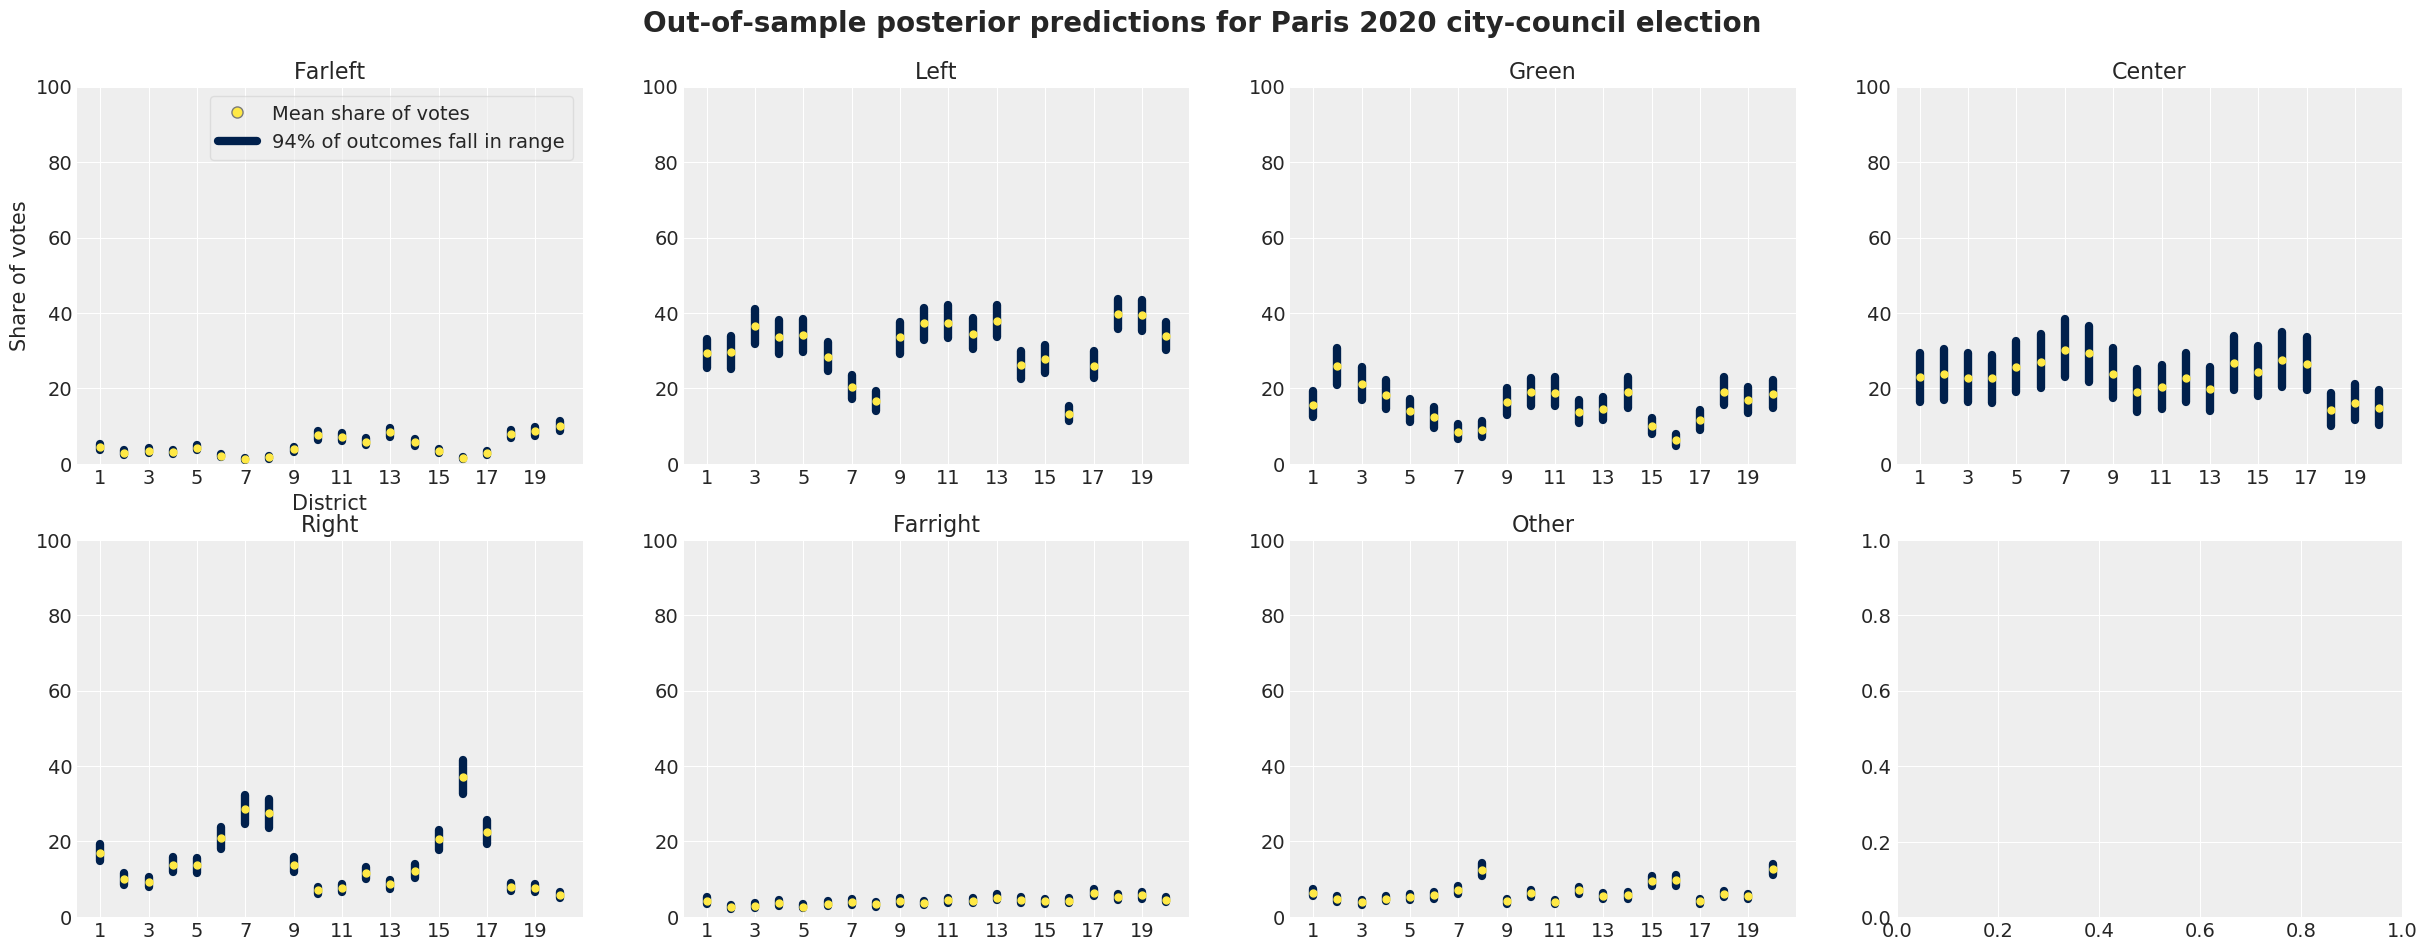

In [160]:
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, :, i].T).T,
            color=cividis(3)[0],
            lw=6,
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[:, i],
            "o",
            color=cividis(3)[2],
            ms=5,
        )
        ax.set_xticks(range(Ndistricts)[::2])
        ax.set_xticklabels(range(1, Ndistricts + 1)[::2])
        ax.set_title(f"{PARTIES[i].title()}")
        ax.set_ylim([-0.05, 100.])
        if i == 0:
            ax.set_xlabel("District")
            ax.set_ylabel("Share of votes")
            ax.plot([], "o", markeredgecolor=cividis(3)[1], markeredgewidth=1, color=cividis(3)[2], ms=8, label="Mean share of votes")
            ax.plot([], label="94% of outcomes fall in range", color=cividis(2)[0], lw=6)
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    "Out-of-sample posterior predictions for Paris 2020 city-council election", y=0.95, size=20, weight="bold",
);

In [161]:
win_summary = {}
for district in range(Ndistricts):
    district_shares = share_est[district]
    district_means = share_mean[district]
    district_hpds = az.hpd(district_shares)

    # compute winner in each simulation:
    order = np.squeeze(np.argsort(-district_shares, axis=1)[:, :1])
    winners = pd.Series(order)
    
    probs = pd.DataFrame(winners.value_counts(normalize=True).multiply(100).round().astype(int))
    probs.columns = ["odds"]
    probs["low"], probs["high"], probs["mean"] = np.nan, np.nan, np.nan
    
    for p_id in probs.index:
        probs.loc[p_id, "low"], probs.loc[p_id, "high"] = district_hpds[p_id]
        probs.loc[p_id, "mean"] = district_means[p_id]
        # assign means to color bins:
        bins_idx = np.digitize(probs.loc[p_id, "mean"], BINS)
        probs.loc[p_id, "color"] = COLORS[PARTIES[p_id]][bins_idx]
    probs.index = np.array(PARTIES)[probs.index]
    probs.index.name = "winner"
    win_summary[district] = probs.reset_index()

win_summary = pd.concat(win_summary).reset_index(level=1)
# keep only most probable winner:
win_summary = win_summary[win_summary.level_1 == 0].drop("level_1", axis=1).set_index(districts)
win_summary.head()

,winner,odds,low,high,mean,color
1,left,90,25.349336,33.209865,29.393399,#c994c7
2,left,71,25.186794,33.856600,29.597333,#c994c7
3,left,99,31.748491,40.955174,36.488252,#df65b0
4,left,98,29.211786,38.053492,33.553978,#c994c7
5,left,92,29.559455,38.408252,34.058436,#c994c7


In [162]:
# https://github.com/gregoiredavid/france-geojson
paris_shape = gpd.read_file("../data/paris_shape.json").sort_values("code").reset_index(drop=True).set_index(districts)
paris_shape = pd.concat([paris_shape, win_summary], axis=1).reset_index()
paris_shape["winner"] = paris_shape["winner"].str.title()
geosource = GeoJSONDataSource(geojson=paris_shape.to_json()) 
paris_shape.head()

,index,code,nom,geometry,winner,odds,low,high,mean,color
0,1,75101,Paris 1er Arrondissement,"POLYGON ((2.32576 48.86955, 2.32787 48.86986, ...",Left,90,25.349336,33.209865,29.393399,#c994c7
1,2,75102,Paris 2e Arrondissement,"POLYGON ((2.35084 48.86334, 2.32787 48.86986, ...",Left,71,25.186794,33.856600,29.597333,#c994c7
2,3,75103,Paris 3e Arrondissement,"POLYGON ((2.35009 48.86195, 2.35084 48.86334, ...",Left,99,31.748491,40.955174,36.488252,#df65b0
3,4,75104,Paris 4e Arrondissement,"POLYGON ((2.34456 48.85399, 2.35009 48.86195, ...",Left,98,29.211786,38.053492,33.553978,#c994c7
4,5,75105,Paris 5e Arrondissement,"POLYGON ((2.34456 48.85399, 2.36432 48.84617, ...",Left,92,29.559455,38.408252,34.058436,#c994c7


In [163]:
p = bkp.figure(title = "Predictions by district for Paris 2020 city-council election",
               align="center",
               plot_height = 350,
               plot_width = 600,
               sizing_mode="scale_both", 
               title_location="above",
               tools = "",
               toolbar_location=None,
              )
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = False
p.outline_line_color = None
p.title.align = "center"
p.title.text_font_size = "1.2rem"
p.background_fill_color = '#e6e6e6'
p.border_fill_color = '#e6e6e6'

district_shapes = p.patches('xs','ys', source=geosource, fill_color="color", fill_alpha=1,
                   line_color = "gray", 
                   line_width = 0.75)
p.add_tools(HoverTool(renderers = [district_shapes],
                      tooltips = [("", 'Paris, District @index'), 
                                  ("Winner", '@winner, with @odds% chance'),
                                  ("Mean", "@mean{1.1} %"),
                                  ("94% HPD", '[@low{1.1} - @high{1.1}] % of votes')]))
show(p)

In [3]:
d = pd.read_excel("../data/results_by_districts_paris.xlsx", index_col=0)
# a party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)
district_id, districts = d.arrondissement.factorize(sort=True)

with open("trace_dos_effects.pkl", "rb") as f:
    data = pickle.load(f)
m_dos_effects, trace_dos_effects = data["model"], data["trace"]
idata = az.from_pymc3(trace_dos_effects)
post = idata.posterior

In [4]:
election = pd.to_datetime("2017-06-11") #np.random.choice(d.date.unique(), replace=False)
election_mask = (d.date == election).to_numpy()

In [5]:
election_est = post.sel(p_district_dim_0=election_mask.nonzero()[0])
election_est["p_district"] = election_est["p_district"] * 100

preds = election_est["p_district"].stack(samples=('chain', 'draw'), districts=("p_district_dim_0", "p_district_dim_1")).to_pandas().reset_index(drop=True)
preds.columns = preds.columns.set_levels([districts, PARTIES])
preds.columns = preds.columns.rename(["districts", "parties"])

In [6]:
win_summary = {}
for dis in districts:
    df = preds[dis]
    winners = get_top_n(df, 1)
    
    probs = pd.DataFrame(winners.top1.value_counts(normalize=True).multiply(100).round().astype(int))
    probs.index.name = "winner"
    probs.columns = ["odds"]
    probs["low"], probs["high"], probs["mean"] = np.nan, np.nan, np.nan
    
    for party in probs.index:
        probs.loc[party, "low"], probs.loc[party, "high"] = az.hpd(df[party])
        probs.loc[party, "mean"] = df[party].mean()
        # assign means to color bins:
        bins_idx = np.digitize(probs.loc[party, "mean"], BINS)
        probs.loc[party, "color"] = COLORS[party][bins_idx]
    win_summary[dis] = probs.reset_index()

win_summary = pd.concat(win_summary).reset_index(level=1)
# keep only most probable winner:
win_summary = win_summary[win_summary.level_1 == 0].drop("level_1", axis=1)

In [7]:
paris_shape = gpd.read_file("../data/paris_shape.json").sort_values("code").reset_index(drop=True).set_index(districts)
paris_shape = pd.concat([paris_shape, win_summary], axis=1).reset_index()
paris_shape["winner"] = paris_shape["winner"].str.title()
paris_shape[["low", "high", "mean"]] = paris_shape[["low", "high", "mean"]].round(1)
geosource = GeoJSONDataSource(geojson=paris_shape.to_json()) 

In [15]:
p = bkp.figure(title = f'Predictions by district for {pd.to_datetime(election).date()} election',
               align="center",
               plot_height = 350,
               plot_width = 600,
               sizing_mode="scale_both", 
               title_location="above",
               tools = "",
               toolbar_location=None,
              )
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = False
p.outline_line_color = None
p.title.align = "center"
p.title.text_font_size = "1.2rem"
p.background_fill_color = '#e6e6e6'
p.border_fill_color = '#e6e6e6'

palette = brewer['Greys'][7][::-1]
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 75)
# custom tick labels for color bar:
tick_labels = {"0": "0", "10": "15", "20": "25", "30": "35", "40": "45", "50": "55", "60": "65", "70": "75+% of votes"}
# create color bar: (needs title and background color): http://docs.bokeh.org/en/latest/docs/reference/models/annotations.html#bokeh.models.annotations.ColorBar
color_bar = ColorBar(color_mapper = color_mapper, background_fill_color='#e6e6e6', title="7 shades of grey:",
                     width = 20, height = 400,
                     border_line_color = None,
                     orientation = "vertical",
                     major_label_overrides = tick_labels)

district_shapes = p.patches('xs','ys', source=geosource, fill_color="color", fill_alpha=1,
                   line_color = "gray", 
                   line_width = 0.75)
p.add_tools(HoverTool(renderers = [district_shapes],
                      tooltips = [("", 'Paris, District @index'), 
                                  ("Winner", '@winner, with @odds% chance'),
                                  ("Mean", "@mean{1.1} %"),
                                  ("94% HPD", '[@low{1.1} - @high{1.1}] % of votes')]))
p.add_layout(color_bar, "right")
show(p)